# Markov Processes

<a id='mc'></a>

Random processes are typically collections of *dependent* random variables, but allowing arbitrary associations between values at different points in time makes analysis intractable.  *Markov processes* are stochastic processes which obey a specific kind of "next step" dependence structure.  For a Markov process, roughly speaking, given the present, the future is conditionally independent of the past.  The dependence assumption in Markov chains allows for a rich
theory and tractable probabilistic models that have applications in a wide range of situations.

<a id='contents'></a>

  1. [**Discrete time Markov chains**](#dtmc)
  1. [**Continuous time Markov chains**](#ctmc)
  1. [**Poisson processes**](#poisson)
  1. [**Brownian motion**](#brownian)
  1. [**Markov process probability spaces**](#mcprobspace)
  1. [**Arrival and jump times**](#times)

Be sure to import Symbulate using the following commands.

In [1]:
from symbulate import *
%matplotlib inline

<a id='dtmc'></a>

### Discrete time Markov chains

A **discrete time Markov chain** is a discrete time, discrete state [random process](process.html) which satisfies for all $n$:

Given $X_n$ ("the present"), $(X_{n+1}, X_{n+2}, \ldots)$ ("the future") is conditionally independent of $(X_{n-1}, X_{n-2}, \ldots, X_0)$ ("the past"). 

In Symbulate a discrete time Markov chain is defined with `MarkovChain`.  The probabilistic behavior of a discrete time Markov chain is fully specified by the following, which are the parameters of `MarkovChain`.

* `state_labels`: The **state space** of possible values of the process.  (Default is to label the states 0, 1, 2, ...)
* `initial_dist`: The **initial distribution**, which specifies the probability distribution at time 0
* `transition_matrix`: The (one-step) **transition probability matrix**, whose $(i, j)$  entry specifies the probability that the chain is in state $j$ at the next time step given that it is currently in state $i$: $P(X_{n+1} = j\, | X_n = i)$.  All rows sums must be 1.



*Example.* The weather in a certain city can be classified as either cloudy, rainy, or sunny and follows a discrete time Markov chain.
* Given that it is cloudy today, tomorrow it will be cloudy with probability 0.3, rainy with probability 0.2, or sunny with probability 0.5.
* Given that it is rainy today, tomorrow it will be cloudy with probability 0.5, rainy with probability 0.3, or sunny with probability 0.2.
* Given that it is sunny today, tomorrow it will be cloudy with probability 0.3, rainy with probability 0, or sunny with probability 0.7.

Suppose that it is sunny on Sunday.  (So we'll call Sunday $n=0$.)

In [2]:
states = ["cloud", "rain", "sun"]

TransitionMatrix = [[0.3, 0.2, 0.5],
                   [0.5, 0.3, 0.2],
                   [0.3, 0.0, 0.7]]

InitialDistribution = [0, 0, 1] # sunny on Sunday

X = MarkovChain(TransitionMatrix, InitialDistribution, states)

Find the probability that it is rainy on Friday ($n=5$).

In [3]:
X[5].sim(10000).tabulate(normalize = True)

cloud,0.3233
rain,0.0949
sun,0.5818
Total,1.0


Find the conditional probability that it is rainy on Friday given that it is rainy on Thursday.  (The following should return, approximately, the second row of the transition matrix.)

In [4]:
(X[5] | (X[4] == "rain")).sim(10000).tabulate(normalize = True)

cloud,0.5
rain,0.3028
sun,0.1972
Total,1.0


Find the conditional probability that it is rainy on Friday given that it is rainy on Thursday and cloudy on Wednesday.  (This demonstrates the Markov property: conditioning additionally on the value of $X_3$ does not change the conditional distribution from the previous part.)

In [5]:
(X[5] | ((X[4] == "rain") & (X[3] == "cloud"))).sim(10000).tabulate(normalize = True)

cloud,0.4981
rain,0.3043
sun,0.1976
Total,1.0


Find the probability that it is rainy on Friday and Saturday.

In [6]:
(X[5] & X[6]).sim(10000).tabulate(normalize = True)

"(cloud, cloud)",0.094
"(cloud, rain)",0.063
"(cloud, sun)",0.1602
"(rain, cloud)",0.0431
"(rain, rain)",0.0236
"(rain, sun)",0.0187
"(sun, cloud)",0.1829
"(sun, sun)",0.4145
Total,1.0


#### State labels

The state space can be any list of values (like ['cloud', 'rain', 'sun']).  If `state_labels` are not specified, the default is to label the states 0, 1, 2, ...  When the states are numerical values, plots can be created, and methods like `.mean()` and `.sd()` can be applied.

In [7]:
TransitionMatrix = [[0.3, 0.2, 0.5],
                   [0.5, 0.3, 0.2],
                   [0.3, 0.0, 0.7]]

InitialDistribution = [0, 0, 1] # sunny on Sunday

X = MarkovChain(TransitionMatrix, InitialDistribution)

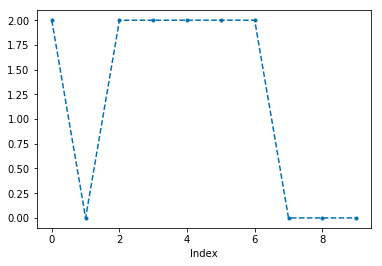

In [8]:
X.sim(1).plot(alpha = 1)

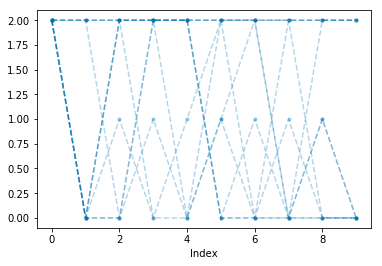

In [9]:
X.sim(10).plot()

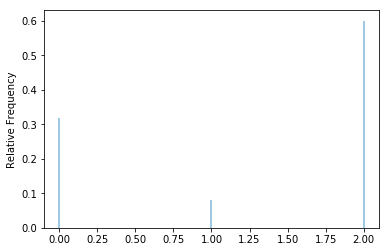

In [10]:
X[5].sim(10000).plot()

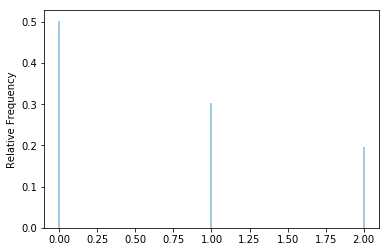

In [11]:
(X[5] | (X[4] == 1) ).sim(10000).plot()

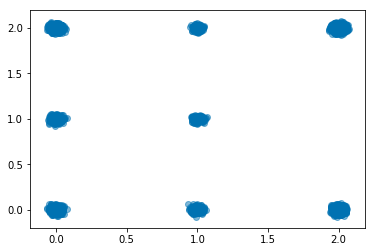

In [12]:
(X[4] & X[5]).sim(10000).plot(jitter = True)

<a id='ctmc'></a>

### Continuous time Markov chains

A **continuous time Markov chain** is a continuous time, discrete state [random process](process.html) which satisfies for all $t$:

Given $X_t$ ("the present"), $(X_{u},u \ge t)$ ("the future") is conditionally independent of $(X_{s}, s \le t )$ ("the past"). 

In a discrete time Markov chain, state transitions occur at every point in time, $n = 0, 1, 2, \ldots$.  A continuous time Markov chain behaves like a discrete time Markov chain in which the times between state transitions are independent and exponentially distributed.

* The amount of time a chain stays in a state has an exponential distribution, with a rate parameter that can depend on the current state.
* When the chain "jumps" to a new state, the jumps behave like a discrete time Markov chain.
* The times between jumps are independent.


In Symbulate a continuous time Markov chain is defined with `ContinuousTimeMarkovChain`.  The probabilistic behavior of a continuous time Markov chain is fully specified by the following, which are the parameters of `ContinuousMarkovChain`.

* `state_labels`: The **state space** of possible values of the process.  (Default is to label the states 0, 1, 2, ...)
* `initial_dist`: The **initial distribution**, which specifies the probability distribution at time 0
* `generator_matrix`: The **generator matrix** or **transition rate matrix**, $Q$, whose $(i, j)$  entry specifies the rate at which the chain "attempts to transition" to state $j$ given that it is currently in state $i$.
  * For small $h$, $P(X_{t+h} = j\, | X_t = i) \approx h q(i,j)$
  * The total departure rate from states $i$ is $\lambda(i) = \sum_{j\neq i} q(i,j)$
  * The diagonal entries are the $-1$ times the total departure rates from each state, $q(i,i) = -\lambda(i)$, so that the all row sums are 0.
  * The probability that when the chain departs state $i$ it jumps to state $j$ is $q(i,j)/\lambda(i)$.

*Example.* The weather in a certain city can be classified as either cloudy, rainy, or sunny and follows a continuous time Markov chain.
* Given that it is cloudy currently, it will next be rainy with probability 0.3, or sunny with probability 0.7.
* Given that it is rainy currently, it will next be cloudy with probability 0.6 or sunny with probability 0.4.
* Given that it is sunny currently, it will next be cloudy with probability 1.
* On average it stays cloudy for 2 days, rainy for 1 day, and sunny for 3 days.

Suppose that it is currently sunny.

In [13]:
states = ["cloud", "rain", "sun"]

Q = [[-0.50, 0.15, 0.35],
     [ 0.60,   -1, 0.40],
     [  1/3,  0.0, -1/3]]

InitialDistribution = [0, 0, 1] # sunny currently

X = ContinuousTimeMarkovChain(Q, InitialDistribution, states)

If it is currently sunny, find the probability that it is raining 36 hours from now.

In [14]:
X[1.5].sim(10000).tabulate(normalize = True)

cloud,0.286
rain,0.022
sun,0.692
Total,1.0


Given that it is raining 36 hours from now, find the probability that it is sunny 48 hours from now.

In [15]:
(X[2] | (X[1.5] == "rain")).sim(10000).tabulate(normalize = True)

cloud,0.2281
rain,0.6067
sun,0.1652
Total,1.0


#### State labels

As for discrete time Markov chains, the state space for a continuous time Markov chain can be any list of values (like ['cloud', 'rain', 'sun']).  If `state_labels` are not specified, the default is to label the states 0, 1, 2, ...  When the states are numerical values, plots can be created, and methods like `.mean()` and `.sd()` can be applied.

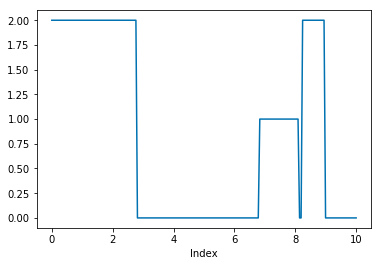

In [16]:
Q = [[-0.50, 0.15, 0.35],
     [ 0.60,   -1, 0.40],
     [  1/3,  0.0, -1/3]]


InitialDistribution = [0, 0, 1] # sunny currently

X = ContinuousTimeMarkovChain(Q, InitialDistribution)

X.sim(1).plot(alpha = 1)

<a id='poisson'></a>

### Poisson processes

Events occurs over time according to a **Poisson process** $N(t), t\ge0$, with rate $\lambda$ if at most one event occurs at a time, the times between events are indepent and exponentially distributed with rate $\lambda$, and $N(t)$ counts the number of events that occur in the time interval $[0,t]$ (with $N(0) = 0$).  In other words, a Poisson process is a continuous time Markov chain whose rate matrix $Q$ satisfies
$$
q(i, j) =
\begin{cases}
\lambda, & j = i+1,\\
-\lambda, & j = i,\\
0, & \text{otherwise.}
\end{cases}
$$

In Symbulate, `PoissonProcess` defines a Poisson process; the single parameter is `rate`.

*Example.* Customers arrive according a Poisson process with rate 2 per minute.

In [17]:
N = PoissonProcess(rate = 2)

Simulate and plot a single sample path, and find the process value for this sample path at time 4

0,11


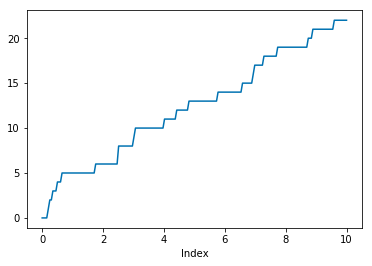

In [18]:
n = N.sim(1)
n.plot(alpha = 1)
n[4]

Simulate many sample paths and plot the mean function

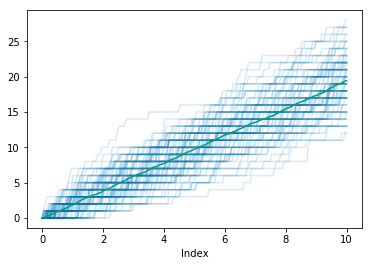

In [20]:
sims = N.sim(100)
sims.plot()
sims.mean().plot()

Approximate the distribution of $N(3)$, the number of customers who arrive in the first 3 minutes, and its mean and variance.  (Should be Poisson(6).)

(5.9961, 6.051084789999999)

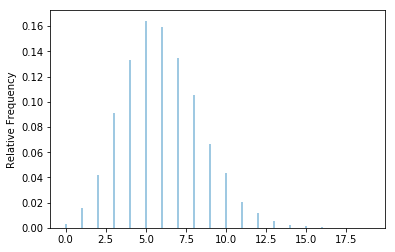

In [21]:
sims = N[3].sim(10000)
sims.plot()
sims.mean(), sims.var()

<a id='mcprobspace'></a>

### Markov chain probability spaces

The examples above illustrate methods for simulating paths of discrete and continuous time Markov chains and process values at specific time points.  However, there are many other random quantities associated with a random process that may be of interest.  Such random quantities can be investigated by first defining a probability space on which all related random processes and random variables are defined.  Symbulate includes probability spaces upon which Markov chains and related quantities can be defined.

The following example defines a probability space which supports the weather chain from above.

In [25]:
states = ["cloud", "rain", "sun"]

TransitionMatrix = [[0.3, 0.2, 0.5],
                   [0.5, 0.3, 0.2],
                   [0.3, 0.0, 0.7]]

InitialDistribution = [0, 0, 1] # sunny on Sunday

P = MarkovChainProbabilitySpace(TransitionMatrix, InitialDistribution, states)

A Markov chain can then be defined as a (sequence of) `RV` on this probability space.

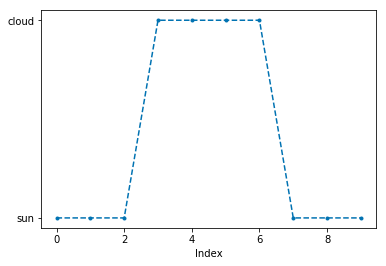

In [28]:
X = RV(P)

X.sim(1).plot()

Symbulate also contains probability spaces supporting continuous time Markov chains

<a id='times'></a>

### Arrival and jump times

For continuous time Markov chains (including Poisson processes) the times between jumps (or arrivals) and the times of the jumps themselves are random variables.  These random times can be accessed with `.JumpTimes()` or `InterjumpTimes()`.  The jump times and interjump times are sequences; individual components can be accessed with brackets, e.g. `.JumpTimes()[1]` for the time of the first jump.

The sequences of states the chain visits can be accessed with `.States()`.

*Example*.  Continuing the weather example.

In [22]:
states = ["cloud", "rain", "sun"]

Q = [[-0.50, 0.15, 0.35],
     [ 0.60,   -1, 0.40],
     [  1/3,  0.0, -1/3]]


InitialDistribution = [0, 0, 1] # sunny currently

X = ContinuousTimeMarkovChain(Q, InitialDistribution, states)

Simulate the jump times for one sample path.

In [23]:
X.JumpTimes().sim(1)

AttributeError: 'ContinuousTimeMarkovChain' object has no attribute 'JumpTimes'

Simulate the state sequence for one sample path.

In [ ]:
X.States().sim(1)

Let $T$ denote the time at which the weather moves from being currently sunny to a different state (either rainy or cloudy.)

In [ ]:
T = X.JumpTimes()[1]
sims = T.sim(10000)
sims.plot()
sims.mean(), sims.var()

Note that InterjumpTimes are indexed starting at 0, so `.InterjumpTimes()[0]` is time between time 0 and the first jump, `.InterjumpTimes()[1]` is the time between the first and second jump, etc.

In [ ]:
T = X.InterjumpTimes()[0]
sims = T.sim(10000)
sims.plot()
sims.mean(), sims.var()

For a continuous time Markov chain, the times between jumps are independent.

In [ ]:
sims = (X.InterjumpTimes()[0] & X.InterjumpTimes()[1]).sim(10000)
sims.plot(alpha = 0.1)
sims.corr()

For a `PoissonProcess`, arrival times and interarrival times can be accessed with `.ArrivalTimes()` and `.InterarrivalTimes()`.

*Example.* Let $N$ be a Poisson process with rate 2.  

In [ ]:
N = PoissonProcess(rate = 2)

Simulate the arrival times for one sample path.

In [ ]:
N.ArrivalTimes().sim(1)

Let $T$ be the time of the first arrival. Approximate the distribution of $T$, and its mean and variance.  (Should be Exponential with rate 2.)

In [ ]:
T = N.ArrivalTimes()[1]
t = T.sim(10000)
t.plot()
t.mean(), t.var()

Approximate the conditional distribution of $T$ given that there is exactly 1 arrival in the first 3 units of time.  (Should be Uniform on (0,3).)

In [ ]:
(T | (N[3] == 1)).sim(10000).plot()

The times between the first two arrivals should be independent 

In [ ]:
W0 = N.InterarrivalTimes()[0]
W1 = N.InterarrivalTimes()[1]

sims = (W0 & W1).sim(10000)
sims.plot()
sims.corr()